In [43]:
# You might need to install oddt:    conda install -c oddt oddt

from oddt import metrics
from sklearn.metrics import average_precision_score as avp
from sklearn.metrics import plot_precision_recall_curve, roc_curve

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign
from rdkit.Chem import rdMolDescriptors

from copy import deepcopy
from espsim import GetShapeSim, GetEspSim
from espsim.helpers import mlCharges
from joblib import Parallel,  delayed

import urllib.request
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
#Download files from https://github.com/ljmartin/d4-rescore

url = 'https://github.com/ljmartin/d4-rescore/raw/main/data/41586_2019_917_MOESM4_ESM.csv'
filename = 'data_benchmark_3/raw_data.csv'
urllib.request.urlretrieve(url, filename)

url = 'https://github.com/ljmartin/d4-rescore/raw/main/data/ligands3d_docked.sdf'
filename = 'data_benchmark_3/ligands3d_docked.sdf'
urllib.request.urlretrieve(url, filename)

url = 'https://github.com/ljmartin/d4-rescore/raw/main/data/AQD_ligand.pdb'
filename = 'data_benchmark_3/AQD_ligand.pdb'
urllib.request.urlretrieve(url, filename)

('data_benchmark_3/AQD_ligand.pdb',
 <http.client.HTTPMessage at 0x7fec12773b90>)

In [49]:
def load_sdf(fname):
    mols = []
    sup = Chem.SDMolSupplier(fname)
    for m in sup:
        if m is not None:
            mols.append(Chem.AddHs(m,addCoords=True))
    names = [m.GetProp('_Name') for m in mols]
    affinities = [float(m.GetProp('minimizedAffinity')) for m in mols]
    return pd.DataFrame({'mol_h':mols, 'ZINC ID':names, 'Smina Score':affinities})

df = pd.read_csv('data_benchmark_3/raw_data.csv',).iloc[:-4]
df['Inhibition (%) at 10uM'] = df['Inhibition (%) at 10uM'].astype(float)
mols_df = load_sdf('data_benchmark_3/ligands3d_docked.sdf')
pdb = Chem.AddHs(Chem.MolFromPDBFile('data_benchmark_3/AQD_ligand.pdb'),addCoords=True)

mols=mols_df['mol_h']

#Precompute charges, which considerably speeds up esp calculation:
charges={}
charges['query']={}
charges['ref']={}
print("Computing Gasteiger charges")
charges['query']['gasteiger']={}
for i,m in enumerate(mols):
    charges['query'][i]={}
    AllChem.ComputeGasteigerCharges(m)
    charges['query'][i]['gasteiger']=[a.GetDoubleProp('_GasteigerCharge') for a in m.GetAtoms()]
AllChem.ComputeGasteigerCharges(pdb)
charges['ref']['gasteiger'] = [a.GetDoubleProp('_GasteigerCharge') for a in pdb.GetAtoms()]

print("Computing MMFF charges")
charges['query']['mmff']={}
for i,m in enumerate(mols):
    mp = AllChem.MMFFGetMoleculeProperties(m)
    charges['query'][i]['mmff']=[mp.GetMMFFPartialCharge(i) for i in range(m.GetNumAtoms())]
mp = AllChem.MMFFGetMoleculeProperties(pdb)
charges['ref']['mmff']=[mp.GetMMFFPartialCharge(i) for i in range(pdb.GetNumAtoms())]

print("Computing ML charges (will print warnings for failed predictions because RDKit doesn't like some of the sdfs)")
for i,c in enumerate(mlCharges(mols)):
    charges['query'][i]['ml']=c
charges['ref']['ml']=mlCharges([pdb])[0]

Computing Gasteiger charges
Computing MMFF charges
Computing ML charges (will print warnings for failed predictions because RDKit doesn't like some of the sdfs)


In [50]:
def AlignScore(prbMol,refMol,prbCharge,refCharge):
    #Need to copy mols, otherwise the alignment will change the positions of the molecule object permanently
    prbMol=deepcopy(prbMol)
    refMol=deepcopy(refMol)
    prbCrippen = rdMolDescriptors._CalcCrippenContribs(prbMol)
    refCrippen = rdMolDescriptors._CalcCrippenContribs(refMol)
    alignment = rdMolAlign.GetCrippenO3A(prbMol, refMol, prbCrippen, refCrippen)
    alignment.Align()
    shape = GetShapeSim(prbMol,refMol)    
    tani_esp=GetEspSim(prbMol,refMol,prbCharge=prbCharge['mmff'],refCharge=refCharge['mmff'],renormalize = True, metric='tanimoto')
    tani_esp_gasteiger=GetEspSim(prbMol,refMol,prbCharge=prbCharge['gasteiger'],refCharge=refCharge['gasteiger'],renormalize = True, metric='tanimoto')
    tani_esp_ml=GetEspSim(prbMol,refMol,prbCharge=prbCharge['ml'],refCharge=refCharge['ml'],renormalize = True, metric='tanimoto')
    
    return shape*tani_esp_ml, shape+tani_esp,shape+tani_esp_gasteiger, shape+tani_esp_ml


def MultiAlignScore(prbMol,refMol,prbCharge,refCharge):
    #Need to copy mols, otherwise the alignment will change the positions of the molecule object permanently
    prbMol=deepcopy(prbMol)
    refMol=deepcopy(refMol)
    prbCrippen = rdMolDescriptors._CalcCrippenContribs(prbMol)
    refCrippen = rdMolDescriptors._CalcCrippenContribs(refMol)
    
    #Find best conformer, only keep best conformer
    alignment = rdMolAlign.GetCrippenO3AForProbeConfs(prbMol, refMol, 1, prbCrippen, refCrippen)
    best=max((a.Score(),i) for i,a in enumerate(alignment))[1]
    alignment[best].Align() 
    save=prbMol.GetConformers()[best]
    prbMol.RemoveAllConformers()
    prbMol.AddConformer(save,assignId=True)

    alignment = rdMolAlign.GetCrippenO3A(prbMol, refMol, prbCrippen, refCrippen)
    alignment.Align()
    shape = GetShapeSim(prbMol,refMol)            
    
    tani_esp=GetEspSim(prbMol,refMol,prbCharge=prbCharge['mmff'],refCharge=refCharge['mmff'],renormalize = True, metric='tanimoto')
    tani_esp_gasteiger=GetEspSim(prbMol,refMol,prbCharge=prbCharge['gasteiger'],refCharge=refCharge['gasteiger'],renormalize = True, metric='tanimoto')
    tani_esp_ml=GetEspSim(prbMol,refMol,prbCharge=prbCharge['ml'],refCharge=refCharge['ml'],renormalize = True, metric='tanimoto')
    
    return shape+tani_esp,shape+tani_esp_gasteiger, shape+tani_esp_ml
    

def Score(prbMol,refMol,prbCharge,refCharge):
    shape = GetShapeSim(prbMol,refMol)
    tani_esp=GetEspSim(prbMol,refMol,prbCharge=prbCharge['mmff'],refCharge=refCharge['mmff'],renormalize = True, metric='tanimoto')
    tani_esp_gasteiger=GetEspSim(prbMol,refMol,prbCharge=prbCharge['gasteiger'],refCharge=refCharge['gasteiger'],renormalize = True, metric='tanimoto')
    tani_esp_ml=GetEspSim(prbMol,refMol,prbCharge=prbCharge['ml'],refCharge=refCharge['ml'],renormalize = True, metric='tanimoto')
        
    return shape+tani_esp,shape+tani_esp_gasteiger, shape+tani_esp_ml
    
def embed(mol):
    m=deepcopy(mol)
    AllChem.EmbedMolecule(m,clearConfs=True)
    return m

def embed_multi(mol,n=10):
    m=deepcopy(mol)
    AllChem.EmbedMultipleConfs(m, n, AllChem.ETKDGv2())
    return m

In [51]:
systems=['Shape+ESP Sim MMFF','Shape+ESP Sim Gasteiger','Shape+ESP Sim ML']

print("Scoring docked poses")
results = Parallel(n_jobs=8, verbose=1)(delayed(Score)(m,pdb,charges['query'][i],charges['ref']) for i,m in enumerate(mols))
for i in range(len(systems)):
    mols_df['Docked pose'+systems[i]] = [x[i] for x in results]

print("Scoring realigned docked poses")
results = Parallel(n_jobs=8, verbose=1)(delayed(AlignScore)(m,pdb,charges['query'][i],charges['ref']) for i,m in enumerate(mols))
for i in range(len(systems)):
    mols_df['Realigned docked pose'+systems[i]] = [x[i] for x in results]
    
print("Embedding one random conformation")
mols2 = Parallel(n_jobs=8, verbose=1)(delayed(embed)(mol) for mol in mols)
print("Scoring random poses (1)")
results = Parallel(n_jobs=8, verbose=1)(delayed(AlignScore)(m,pdb,charges['query'][i],charges['ref']) for i,m in enumerate(mols2))
for i in range(len(systems)):
    mols_df['Random pose (1)'+systems[i]] = [x[i] for x in results]

print("Embedding 10 random conformations")
mols2 = Parallel(n_jobs=8, verbose=1)(delayed(embed_multi)(mol) for mol in mols2)
print("Scoring random poses (10)")
results = Parallel(n_jobs=8, verbose=1)(delayed(MultiAlignScore)(m,pdb,charges['query'][i],charges['ref']) for i,m in enumerate(mols2))
for i in range(len(systems)):
    mols_df['Random pose (10)'+systems[i]] = [x[i] for x in results]

Scoring docked poses


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done 1560 tasks      | elapsed:    9.5s
[Parallel(n_jobs=8)]: Done 4933 out of 4933 | elapsed:   14.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Scoring realigned docked poses


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:    8.8s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   16.0s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   25.5s
[Parallel(n_jobs=8)]: Done 4918 out of 4933 | elapsed:   25.8s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 4933 out of 4933 | elapsed:   25.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Embedding one random conformation


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   14.7s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   26.2s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   41.0s
[Parallel(n_jobs=8)]: Done 4933 out of 4933 | elapsed:   41.5s finished


Scoring random poses (1)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:    9.4s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   16.5s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   25.7s
[Parallel(n_jobs=8)]: Done 4918 out of 4933 | elapsed:   26.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 4933 out of 4933 | elapsed:   26.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Embedding 10 random conformations


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   15.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   35.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  5.3min
[Parallel(n_jobs=8)]: Done 4933 out of 4933 | elapsed:  6.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Scoring random poses (10)


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    9.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   22.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   40.5s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 4933 out of 4933 | elapsed:  3.8min finished


,BEDROC,RIE,log ROC AUC,ROC AUC,Average Precision
Algorithm,,,,,
Docked poseShape+ESP Sim MMFF,0.383753,1.706610,0.183055,0.553250,0.284610
Realigned docked poseShape+ESP Sim MMFF,0.358781,1.595554,0.190368,0.583023,0.292437
Random pose (1)Shape+ESP Sim MMFF,0.346326,1.540164,0.203567,0.615695,0.311242
Random pose (10)Shape+ESP Sim MMFF,0.362380,1.611558,0.199752,0.605271,0.303303
Docked poseShape+ESP Sim Gasteiger,0.287977,1.280680,0.181339,0.597631,0.274949
Realigned docked poseShape+ESP Sim Gasteiger,0.331811,1.475616,0.180504,0.556225,0.280649
Random pose (1)Shape+ESP Sim Gasteiger,0.301782,1.342072,0.199152,0.613602,0.302647
Random pose (10)Shape+ESP Sim Gasteiger,0.355477,1.580861,0.205356,0.629151,0.310706
Docked poseShape+ESP Sim ML,0.265921,1.182594,0.176387,0.594329,0.268375


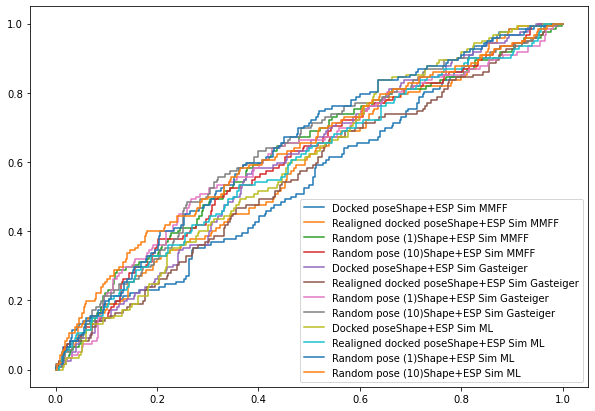

In [52]:
results = []
plt.figure(figsize=(10,7))

all_systems=[x+systems[i] for i in range(len(systems)) for x in ['Docked pose','Realigned docked pose','Random pose (1)','Random pose (10)']]
for col in all_systems:    
    srtd = mols_df.sort_values(col, ascending=False).drop_duplicates('ZINC ID')
    merged= srtd.merge(df[['ZINC ID', 'Inhibition (%) at 10uM']])
    labels = merged['Inhibition (%) at 10uM']>50
    preds = merged[col]
    
    fpr, tpr, thresholds= roc_curve(labels, preds)
    plt.plot(fpr, tpr, label=col)
    
    bedroc = metrics.bedroc(labels.values, merged[col].values)
    rie = metrics.rie(labels.values, merged[col].values)
    roc_log_auc = metrics.roc_log_auc(labels.values, merged[col].values, ascending_score=False)
    roc_auc = metrics.roc_auc(labels.values, merged[col].values, ascending_score=False)
    
    ap = avp(labels,  preds)
    results.append([col, bedroc, rie, roc_log_auc, roc_auc, ap])
plt.legend()

results_df = pd.DataFrame(data=results, columns=['Algorithm', 'BEDROC', 'RIE', 'log ROC AUC', 'ROC AUC', 'Average Precision'])
results_df.set_index('Algorithm').style.highlight_max(color = 'lightgreen', axis = 0)